In [1]:
import numpy as np
import pandas as pd
import pyreadr
import datetime
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS

def rounder(x, prec=2, base=.05):
    return round(base * round(float(x) / base), prec)


In [2]:
# define paths
data_path = '/Users/simonneumeyer/Dropbox/Ethiopia IE - Road Safety/Data/'
crashes_path = 'ETRE - Crashes/'
crash_file = 'FinalData/crashes.csv'
traffic_path = 'ETRE - Traffic/'
traffic_file = 'FinalData/traffic.pq'
precipitation_path = 'Precipitation/'
precipitation_file = 'FinalData/precipitation.csv'

In [3]:
# load data
#traffic_final = pd.read_parquet(data_path + traffic_path + traffic_file, engine='pyarrow')
precipitation_final = pd.read_csv(data_path + precipitation_path + precipitation_file)
crashes_final = pd.read_csv(data_path + crashes_path + crash_file)

traffic = pd.read_parquet(data_path + 'Time Segment Data/traffic_feature.pq', engine='pyarrow')
hourly = pd.read_stata(data_path + 'Daily and Hourly Data/FinalData/hourly.dta')

# segment-time panel

In [4]:
# create rectangularized segment-time dataset:
date_range = pd.date_range(precipitation_final.date.min(), precipitation_final.date.max())
date_range = list(date_range)
hour_range = list(range(0,24))
km_range = [x for x in range(0,79)]
directions = ['to addis', 'to adama']
segment_time = pd.DataFrame([[x,y,z,w] for x in date_range for y in hour_range for z in km_range for w in directions])
segment_time = segment_time.rename(columns={0:'date', 1:'hour', 2:'km_from_addis', 3:'direction'})

# crashes & precipitation:

In [5]:
crashes_final.direction.value_counts(normalize=True, dropna=False)

to adama    0.433393
to addis    0.388988
NaN         0.177620
Name: direction, dtype: float64

In [6]:
# rename date & hour:
crashes_final = crashes_final.rename(columns={'accident_date': 'date', 'time_of_accident_hour': 'hour'})

# create accident counts and add them to segment-time dataset:
crashes_final['accidents'] = 1
crashes_final['km_from_addis'] = crashes_final.distance_from_addis.round(-3).apply(lambda x: x/1000)
accid_count = crashes_final.groupby(['date', 'hour', 'km_from_addis', 'direction'])['accidents'].count()
accid_count = accid_count.reset_index()
accid_count.date = pd.to_datetime(accid_count.date)
segment_time = segment_time.merge(accid_count, how='left', on=['date', 'hour', 'km_from_addis', 'direction'], validate='one_to_one')

In [7]:
# add precipitation:
precipitation_final.date = pd.to_datetime(precipitation_final.date)
segment_time = segment_time.merge(precipitation_final[['date', 'precip_mm']], on='date', how='left', validate='many_to_one')

In [8]:
# fill missing data with 0 only for the date range where we have crashes data (2015-2017)
crashes_start_date = pd.to_datetime('2015-01-01')
crashes_end_date = pd.to_datetime(crashes_final.date).max()
condition = (segment_time['date'] >= crashes_start_date) & (segment_time['date'] <= crashes_end_date)
segment_time.loc[condition, 'accidents'] = segment_time.loc[condition, 'accidents'].fillna(0)

## crashes:

In some cases there are multiple accidents in a given time-segment and for that I apply an appropriate aggregation method to each of the variables (e.g. the mode for categoricals):

In [9]:
categoricals = ['vehicle_brand', 
    'direction', 
    'road_geometry', 
    'road', 
    'weather', 
    'cause_of_accident', 
    'type_of_accident',
    'year_of_production', 
    'owner', 
    'driver_age',
    'gender',
    'address',
    'drivers_license_level',
    'license_year',
    'license_region',
    'accident_location_text',
    'extent_of_damage',
    'axle_number',
    'cause_of_accident_simple',
    'type_of_accident_simple',
    'accident_cause_vehicle_human']

for col in categoricals:
    crashes_final[col] = crashes_final[col].astype(str)
    crashes_final[col] = crashes_final[col].apply(lambda x: x.replace("[]", ""))

In [10]:
crashes_final = crashes_final.groupby(['date', 'hour', 'km_from_addis']).agg(
{
    'vehicle_type': 'median', 
    'vehicle_brand': pd.Series.mode, 
    'direction': pd.Series.mode, 
    'road_geometry': pd.Series.mode, 
    'road': pd.Series.mode, 
    'weather': pd.Series.mode, 
    'fatality': 'sum', 
    'serious_injury': 'sum',
    'slight_injury': 'sum', 
    'cause_of_accident': pd.Series.mode, 
    'type_of_accident': pd.Series.mode,
    'year_of_production': pd.Series.mode, 
    'owner': pd.Series.mode, 
    'driver_age': pd.Series.mode,
    'gender': pd.Series.mode,
    'address': pd.Series.mode,
    'drivers_license_level': pd.Series.mode,
    'license_year': pd.Series.mode,
    'license_region': pd.Series.mode,
    'accident_location_text': pd.Series.mode,
    'extent_of_damage': pd.Series.mode,
    'axle_number': pd.Series.mode,
    'cause_of_accident_simple': pd.Series.mode,
    'type_of_accident_simple': pd.Series.mode,
    'accident_cause_vehicle_human': pd.Series.mode
}
).reset_index()

# the mode function creates empty arrays instead of Nans when there are no NAs. Therefore below transformation:
for col in categoricals:
    crashes_final[col] = crashes_final[col].astype(str)
    crashes_final[col] = crashes_final[col].apply(lambda x: x.replace("[]", ""))

In [11]:
# merging crashes data into it:
relevant_crash_vars = ['date', 
                       'hour', 
                       'km_from_addis',
                        'vehicle_type', 
                        'vehicle_brand', 
                        'direction', 
                        'road_geometry', 
                        'road', 
                        'weather', 
                        'fatality', 
                        'serious_injury',
                        'slight_injury',
                        'cause_of_accident',
                        'type_of_accident',
                        'year_of_production',
                        'owner',
                        'driver_age',
                        'gender',
                        'address',
                        'license_year',
                        'license_region',
                        'drivers_license_level',
                        'accident_location_text',
                        'extent_of_damage',
                        'axle_number',
                        'cause_of_accident_simple',
                        'type_of_accident_simple',
                        'accident_cause_vehicle_human'
                      ]

crashes_final.date = pd.to_datetime(crashes_final.date)
segment_time = segment_time.merge(crashes_final[relevant_crash_vars], how='left', on=['date', 'hour', 'km_from_addis', 'direction'], validate='one_to_one')


In [12]:
# option to load intermediate file:
#segment_time = pd.read_parquet(data_path + 'Time Segment Data/segment_time_panel_intermediate.pq', engine='pyarrow')


# preprocess

In [13]:
# kick out NAs: (where we don't have accident data)
segment_time = segment_time.dropna(subset=['accidents'])
segment_time = segment_time.reset_index()

traffic = traffic.rename({'tstamp': 'date', 'count': 'traffic', 'km':'km_from_addis'}, axis=1)

In [14]:
traffic.head(5)

,date,hour,km_from_addis,direction,cars,total_weight,speed_km_hr,veh_type_1,veh_type_2,veh_type_3,veh_type_4,veh_type_5,veh_type_6,veh_type_7,speed_sec_km
0,2009-07-14,15,52,to adama,40,5101.000000,0.0,0.700000,0.100000,0.050000,0.150000,0.000000,0.0,0.0,5.968006e+05
1,2009-07-14,16,52,to adama,54,2438.518519,0.0,0.888889,0.074074,0.037037,0.000000,0.000000,0.0,0.0,4.598650e+05
2,2009-07-14,16,52,to addis,2,9700.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,1.369440e+07
3,2009-07-14,17,52,to adama,130,2862.461538,0.0,0.815385,0.092308,0.061538,0.015385,0.015385,0.0,0.0,1.713582e+05
4,2009-07-14,18,52,to adama,108,2817.037037,0.0,0.796296,0.148148,0.018519,0.037037,0.000000,0.0,0.0,3.664364e+05


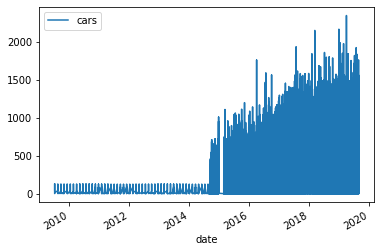

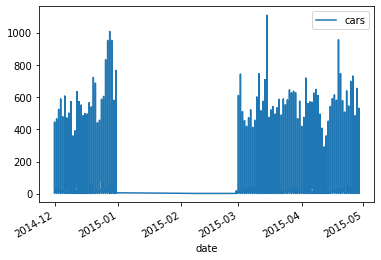

In [15]:
# show why we drop some data:

#segment_time.fillna(0).plot(x='date', y='count')
traffic.plot(x='date', y='cars')
plt.show()
#traffic
cond_1 = (traffic.date > pd.to_datetime('2014-11-30'))
cond_2 = (traffic.date < pd.to_datetime('2015-04-30'))

traffic[cond_1 & cond_2].plot(x='date', y='cars')
plt.show()
# It seems that there is a 2-month gap of traffic data for January & February 2015. 
# We shall consider only traffic data after February 2015 (Before 2015 there is no accidents data anyway)

In [16]:
# drop accident data older than March 2015:
condition = (segment_time.date >= pd.to_datetime('2015-03-01'))
segment_time = segment_time[condition]

In [17]:
# binarize accidents column:
segment_time.accidents = segment_time.accidents.apply(lambda x: 1 if x>1 else x)

# traffic and hourly (and segment) data:

In [18]:
# merge traffic with accidents:
segment_time = segment_time.merge(traffic, how='left', on=['date', 'hour', 'km_from_addis', 'direction'])

In [19]:
# Now that we removed missing data we can safely assume that remaining traffic NAs are incidents of 
# no traffic in that particular time-km segment:
segment_time['cars'] = segment_time['cars'].fillna(0)

In [20]:
# add hourly data:

hourly['hour'] = hourly.date_hour.apply(lambda x: x.hour)
hourly = hourly.drop('precip_mm', axis=1)

# aggregate both directions (subject to change):
hourly = hourly.groupby(['date_hour', 'direction']).agg(
    {
    'speed_mean': 'mean', 'speed_p10': 'mean', 'crash': 'sum', 'speed_p25': 'mean',
        'speed_p50': 'mean', 'speed_p75': 'mean', 'speed_p90': 'mean', 
        'N_crashes': 'sum', 'N_vehicles': 'sum', 'holiday': 'mean', 
        'holiday_plusminus_1day': 'mean', 'holiday_plusminus_2day': 'mean',
        'hour': 'mean', 'date': 'min'
    }
).reset_index()

# merge with time-segment panel:
segment_time = segment_time.merge(hourly, how='left', on=['date', 'hour', 'direction'], validate='many_to_one')

In [21]:
# add segment data:
segment_data = pyreadr.read_r(data_path + 'Addis Adama Expressway/Data/segments_data/merged_data/aae_segment_data.Rds')
segment_data = segment_data[None]

# round and scale and rename km variable:
segment_data['distance_from_addis'] = segment_data['distance_from_addis'].apply(lambda x: rounder(x, prec=2, base=1000))
segment_data['distance_from_addis'] = segment_data['distance_from_addis'] / 1000
segment_data = segment_data.rename(columns={'distance_from_addis': 'km_from_addis'})

In [22]:
segment_data = segment_data.groupby('km_from_addis').agg(
{
    'N_crashes': 'sum', 'N_crashes_to_addis': 'sum', 'N_crashes_to_adama': 'sum',
    'N_crashes_2015': 'sum', 'N_crashes_2017': 'sum', 'N_crashes_2016': 'sum', 	
    'N_crashes_to_addis_2015': 'sum', 'N_crashes_to_adama_2017': 'sum', 'N_crashes_to_addis_2017': 'sum',
    'N_crashes_to_addis_2016': 'sum', 'N_crashes_to_adama_2016': 'sum', 'N_crashes_to_adama_2015': 'sum',
    'turnangle_10m': 'mean', 'turnangle_50m': 'mean', 'turnangle_100m': 'mean',
    'turnangle_250m': 'mean', 'turnangle_500m': 'mean', 'N_crashes_MA_sum_500m': 'mean',
    'N_crashes_to_addis_MA_sum_500m': 'mean', 'N_crashes_to_adama_MA_sum_500m': 'mean', 
    'N_crashes_2015_MA_sum_500m': 'mean', 'turnangle_250m': 'mean', 'turnangle_500m': 'mean', 
    'N_crashes_2017_MA_sum_500m': 'mean', 'N_crashes_2016_MA_sum_500m': 'mean', 
    'N_crashes_to_addis_2015_MA_sum_500m': 'mean', 'N_crashes_to_adama_2017_MA_sum_500m': 'mean',
    'N_crashes_to_addis_2017_MA_sum_500m': 'mean', 'N_crashes_to_addis_2016_MA_sum_500m': 'mean', 
    'N_crashes_to_adama_2016_MA_sum_500m': 'mean', 'N_crashes_to_adama_2015_MA_sum_500m': 'mean', 
    'N_crashes_MA_sum_1000m': 'mean', 'N_crashes_to_addis_MA_sum_1000m': 'mean',
    'N_crashes_to_adama_MA_sum_1000m': 'mean', 'N_crashes_2015_MA_sum_1000m': 'mean', 
    'N_crashes_2017_MA_sum_1000m': 'mean', 'N_crashes_2016_MA_sum_1000m': 'mean',
    'N_crashes_to_addis_2015_MA_sum_1000m': 'mean', 'N_crashes_to_adama_2017_MA_sum_1000m': 'mean',
    'N_crashes_to_addis_2017_MA_sum_1000m': 'mean', 'N_crashes_to_addis_2016_MA_sum_1000m': 'mean',
    'N_crashes_to_adama_2016_MA_sum_1000m': 'mean', 'N_crashes_to_adama_2015_MA_sum_1000m': 'mean',
    'turnangle_50m_MA_mean_500m': 'mean', 'turnangle_100m_MA_mean_500m': 'mean',
    'turnangle_250m_MA_mean_500m': 'mean', 'turnangle_500m_MA_mean_500m': 'mean',
    'turnangle_10m_MA_mean_1000m': 'mean', 'turnangle_50m_MA_mean_1000m': 'mean',
    'turnangle_100m_MA_mean_1000m': 'mean', 'turnangle_250m_MA_mean_1000m': 'mean',
    'turnangle_500m_MA_mean_1000m': 'mean'  
}).reset_index()

In [23]:
segment_time = segment_time.merge(segment_data, how='left', on='km_from_addis', validate='many_to_one')

# Aggregate by segment & time:

In [24]:
#segment_time.columns.values

In [25]:
granularity_km_ex_post = 1
granularity_hour_ex_post = 1
segment_time['km_from_addis'] = segment_time.km_from_addis.apply(lambda x: rounder(x, prec=2, base=granularity_km_ex_post))
segment_time['hour'] = segment_time.hour.apply(lambda x: rounder(x, prec=2, base=granularity_hour_ex_post))


segment_time = segment_time.groupby(['date', 'hour', 'km_from_addis', 'direction']).agg(
    {
        'accidents': 'sum', 'precip_mm': 'sum', 'cars': 'sum',
        'speed_mean': 'mean', 'speed_p10': 'mean', 'crash': 'sum', 'speed_p25': 'mean',
        'speed_p50': 'mean', 'speed_p75': 'mean', 'speed_p90': 'mean', 
        'N_vehicles': 'sum', 'holiday': 'mean', 
        
        'total_weight': 'mean', 'speed_km_hr': 'mean', 'veh_type_1': 'mean', 'veh_type_2': 'mean', 
        'veh_type_3': 'mean', 'veh_type_4': 'mean', 'veh_type_5': 'mean', 'veh_type_6': 'mean', 
        'veh_type_7': 'mean', 'speed_sec_km': 'mean',
        
        'holiday_plusminus_1day': 'mean', 'holiday_plusminus_2day': 'mean',
        'N_crashes_x': 'sum', 'N_crashes_y': 'sum', 'N_crashes_to_addis': 'sum', 'N_crashes_to_adama': 'sum',
        'N_crashes_2015': 'sum', 'N_crashes_2017': 'sum', 'N_crashes_2016': 'sum',
        'N_crashes_to_addis_2015': 'sum', 'N_crashes_to_adama_2017': 'sum', 'N_crashes_to_addis_2017': 'sum',
        'N_crashes_to_addis_2016': 'sum', 'N_crashes_to_adama_2016': 'sum', 'N_crashes_to_adama_2015': 'sum',
        'turnangle_10m': 'mean', 'turnangle_50m': 'mean', 'turnangle_100m': 'mean',
        'turnangle_250m': 'mean', 'turnangle_500m': 'mean', 'N_crashes_MA_sum_500m': 'mean',
        'N_crashes_to_addis_MA_sum_500m': 'mean', 'N_crashes_to_adama_MA_sum_500m': 'mean', 
        'N_crashes_2015_MA_sum_500m': 'mean', 'turnangle_250m': 'mean', 'turnangle_500m': 'mean', 
        'N_crashes_2017_MA_sum_500m': 'mean', 'N_crashes_2016_MA_sum_500m': 'mean', 
        'N_crashes_to_addis_2015_MA_sum_500m': 'mean', 'N_crashes_to_adama_2017_MA_sum_500m': 'mean',
        'N_crashes_to_addis_2017_MA_sum_500m': 'mean', 'N_crashes_to_addis_2016_MA_sum_500m': 'mean', 
        'N_crashes_to_adama_2016_MA_sum_500m': 'mean', 'N_crashes_to_adama_2015_MA_sum_500m': 'mean', 
        'N_crashes_MA_sum_1000m': 'mean', 'N_crashes_to_addis_MA_sum_1000m': 'mean',
        'N_crashes_to_adama_MA_sum_1000m': 'mean', 'N_crashes_2015_MA_sum_1000m': 'mean', 
        'N_crashes_2017_MA_sum_1000m': 'mean', 'N_crashes_2016_MA_sum_1000m': 'mean',
        'N_crashes_to_addis_2015_MA_sum_1000m': 'mean', 'N_crashes_to_adama_2017_MA_sum_1000m': 'mean',
        'N_crashes_to_addis_2017_MA_sum_1000m': 'mean', 'N_crashes_to_addis_2016_MA_sum_1000m': 'mean',
        'N_crashes_to_adama_2016_MA_sum_1000m': 'mean', 'N_crashes_to_adama_2015_MA_sum_1000m': 'mean',
        'turnangle_50m_MA_mean_500m': 'mean', 'turnangle_100m_MA_mean_500m': 'mean',
        'turnangle_250m_MA_mean_500m': 'mean', 'turnangle_500m_MA_mean_500m': 'mean',
        'turnangle_10m_MA_mean_1000m': 'mean', 'turnangle_50m_MA_mean_1000m': 'mean',
        'turnangle_100m_MA_mean_1000m': 'mean', 'turnangle_250m_MA_mean_1000m': 'mean',
        'turnangle_500m_MA_mean_1000m': 'mean'
#        'vehicle_type': 'median', 
#        'vehicle_brand': pd.Series.mode, 
#        'direction': pd.Series.mode, 
#        'road_geometry': pd.Series.mode, 
#        'road': pd.Series.mode, 
#        'weather': pd.Series.mode, 
#        'fatality': 'sum', 
#        'serious_injury': 'sum',
#        'slight_injury': 'sum', 
#        'cause_of_accident': pd.Series.mode, 
#        'type_of_accident': pd.Series.mode,
#        'year_of_production': pd.Series.mode, 
#        'owner': pd.Series.mode, 
#        'driver_age': pd.Series.mode,
#        'gender': pd.Series.mode,
#        'address': pd.Series.mode,
#        'drivers_license_level': pd.Series.mode,
#        'license_year': pd.Series.mode,
#        'license_region': pd.Series.mode,
#        'accident_location_text': pd.Series.mode,
#        'extent_of_damage': pd.Series.mode,
#        'axle_number': pd.Series.mode,
#        'cause_of_accident_simple': pd.Series.mode,
#        'type_of_accident_simple': pd.Series.mode,
#        'accident_cause_vehicle_human': pd.Series.mode
    }
).reset_index()

In [26]:
segment_time['accidents'] = segment_time.accidents.apply(lambda x: 1 if x>0 else 0)

# Feature engineering:

In [27]:
# weekend dummy:
segment_time['weekday'] = segment_time.date.dt.dayofweek
segment_time = pd.get_dummies(segment_time, columns=['weekday'])
#weekday_dummies = ['weekday_' + str(n) for n in range(7)]
segment_time['weekend'] = segment_time.apply(lambda x: sum([x.weekday_4, x.weekday_5, x.weekday_6]), axis=1)

In [28]:
# add hour square term:
segment_time['hour_squared'] = segment_time.hour.apply(lambda x: x**2)
# traffic x1000:
segment_time['k_cars'] = segment_time.cars / 1000
# precipitation x10:
segment_time['precip_cm'] = segment_time.precip_mm / 10
# speed x ...:
#segment_time.speed_p90

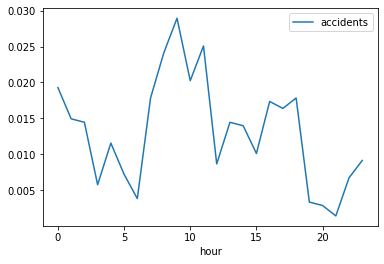

In [29]:
# evening/rush-hour dummies:
segment_time.groupby('hour').mean().reset_index().plot(x='hour', y='accidents')
plt.show()
# rush hour: 7-11, 16-17
segment_time['rush_hour_dummy'] = segment_time.hour.apply(lambda x: 1 if 7 <= x <= 11 or 16 <= x <= 17 else 0)
# midnight dummy: after 23 & before 2: (inclusive)
segment_time['midnight_dummy'] = segment_time.hour.apply(lambda x: 1 if x>=23 or x<=2 else 0)

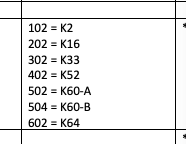

In [30]:
# segment dummy for rain:

accidents_by_km = segment_time.groupby('km_from_addis')['accidents'].sum()
accidents_by_km.plot()
plt.show()
# get segment dummies
def get_segment_dummies(km):
    """
    Segments are based on entry points to the express way:
    """
    if km <= 15:
        return 'rain_seg_1'
    elif 16 <= km <= 32:
        return 'rain_seg_2'
    elif 33 <= km <= 51:
        return 'rain_seg_3'
    elif 52 <= km <= 59:
        return 'rain_seg_4'
    elif 60 <= km <= 63:
        return 'rain_seg_5'
    elif 64 <= km:
        return 'rain_seg_6'

segm_dummies = pd.get_dummies(segment_time.km_from_addis.apply(get_segment_dummies))
segment_time = pd.concat([segment_time, segm_dummies], axis=1)
# multiply the segment dummies by precipitation:
for i in range(1,7):
    segment_time[f'rain_seg_{i}'] = segment_time[f'rain_seg_{i}'] * segment_time['precip_cm']

In [31]:
# make speed significant:

# only take into account when there's little traffic:
median = segment_time.cars.median()
quantile_30 = segment_time.cars.quantile(0.3)
#segment_time['low_traffic_dummy_p50'] = segment_time.cars.apply(lambda x: 1 if x <= median else 0)
segment_time['low_traffic_dummy_p30'] = segment_time.cars.apply(lambda x: 1 if x <= quantile_30 else 0)
#segment_time['speed_low_traffic_p50'] = segment_time.speed_km_hr * segment_time.low_traffic_dummy_p50
segment_time['speed_low_traffic_p30'] = segment_time.speed_km_hr * segment_time.low_traffic_dummy_p30

# only take into account when there's rain:
segment_time['rain_dummy'] = segment_time.precip_cm.apply(lambda x: 1 if x > 0 else 0)
segment_time['speed_rain'] = segment_time.speed_km_hr * segment_time.rain_dummy

# mix the two:
segment_time['speed_low_traffic_and_rain'] = segment_time.speed_rain * segment_time.low_traffic_dummy_p30

In [32]:
segment_time['avg_weight_tons'] = segment_time.total_weight / 1000
segment_time['log_avg_weight_tons'] = np.log(segment_time.avg_weight_tons)

/Users/simonneumeyer/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# save dataset:

In [33]:
segment_time.to_parquet(data_path + f'Time Segment Data/segment_time_panel_km_{granularity_km_ex_post}_hr_{granularity_hour_ex_post}.pq')

In [34]:
segment_time.accidents.value_counts()

0    49121
1      655
Name: accidents, dtype: int64

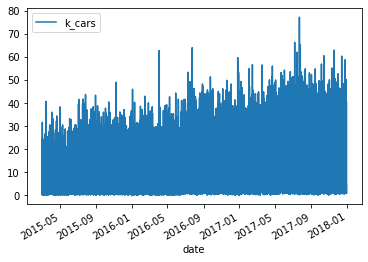

In [35]:
segment_time.plot(x='date', y='k_cars')

In [45]:
segment_data

,km_from_addis,N_crashes,N_crashes_to_addis,N_crashes_to_adama,N_crashes_2015,N_crashes_2017,N_crashes_2016,N_crashes_to_addis_2015,N_crashes_to_adama_2017,N_crashes_to_addis_2017,N_crashes_to_addis_2016,N_crashes_to_adama_2016,N_crashes_to_adama_2015,turnangle_10m,turnangle_50m,turnangle_100m,turnangle_250m,turnangle_500m,N_crashes_MA_sum_500m,N_crashes_to_addis_MA_sum_500m,N_crashes_to_adama_MA_sum_500m,N_crashes_2015_MA_sum_500m,N_crashes_2017_MA_sum_500m,N_crashes_2016_MA_sum_500m,N_crashes_to_addis_2015_MA_sum_500m,N_crashes_to_adama_2017_MA_sum_500m,N_crashes_to_addis_2017_MA_sum_500m,N_crashes_to_addis_2016_MA_sum_500m,N_crashes_to_adama_2016_MA_sum_500m,N_crashes_to_adama_2015_MA_sum_500m,N_crashes_MA_sum_1000m,N_crashes_to_addis_MA_sum_1000m,N_crashes_to_adama_MA_sum_1000m,N_crashes_2015_MA_sum_1000m,N_crashes_2017_MA_sum_1000m,N_crashes_2016_MA_sum_1000m,N_crashes_to_addis_2015_MA_sum_1000m,N_crashes_to_adama_2017_MA_sum_1000m,N_crashes_to_addis_2017_MA_sum_1000m,N_crashes_to_addis_2016_MA_sum_1000m,N_crashes_to_adama_2016_MA_sum_1000m,N_crashes_to_adama_2015_MA_sum_1000m,turnangle_50m_MA_mean_500m,turnangle_100m_MA_mean_500m,turnangle_250m_MA_mean_500m,turnangle_500m_MA_mean_500m,turnangle_10m_MA_mean_1000m,turnangle_50m_MA_mean_1000m,turnangle_100m_MA_mean_1000m,turnangle_250m_MA_mean_1000m,turnangle_500m_MA_mean_1000m
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.426661,2.227266,4.652483,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.563915,2.801113,5.210665,NaN,NaN,0.202020,0.202020,0.000000,0.202020,0.000000,0.000000,0.202020,0.000000,0.000000,0.000000,0.000000,0.000000,1.242424,0.797980,0.444444,0.707071,0.535354,0.000000,0.707071,0.444444,0.090909,0.000000,0.000000,0.000000,2.627596,4.858020,NaN,NaN,0.401367,1.987169,3.704914,NaN,NaN
2,2.0,3.0,2.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.130170,0.619885,1.142904,NaN,NaN,2.544554,1.603960,0.940594,0.801980,1.534653,0.207921,0.801980,0.940594,0.594059,0.207921,0.000000,0.000000,7.207921,5.524752,1.683168,1.603960,3.435644,2.168317,1.603960,1.683168,1.752475,2.168317,0.000000,0.000000,0.718965,1.390230,NaN,NaN,0.205174,1.024290,1.934187,NaN,NaN
3,3.0,13.0,9.0,4.0,2.0,6.0,5.0,2.0,4.0,2.0,5.0,0.0,0.0,0.094584,0.486180,1.012133,21.088304,NaN,11.959596,9.222222,2.737374,1.939394,5.151515,4.868687,1.939394,2.737374,2.414141,4.868687,0.000000,0.000000,20.848485,15.787879,5.060606,3.161616,9.666667,8.020202,3.141414,4.565657,5.101010,7.545455,0.474747,0.020202,0.534753,1.070730,17.654538,NaN,0.150162,0.750787,1.502569,NaN,NaN
4,4.0,13.0,11.0,2.0,2.0,6.0,5.0,1.0,0.0,6.0,4.0,1.0,1.0,0.367272,1.823357,3.607713,9.012991,NaN,16.287129,12.960396,3.158416,1.633663,7.356436,7.297030,1.108911,1.376238,5.811881,6.039604,1.257426,0.524752,35.772277,28.851485,6.257426,4.792079,16.920792,14.059406,3.712871,3.356436,12.900990,12.237624,1.821782,1.079208,1.520937,3.048945,9.097231,NaN,0.256383,1.281834,2.563531,10.234416,NaN
5,5.0,25.0,21.0,3.0,4.0,12.0,9.0,3.0,0.0,11.0,7.0,2.0,1.0,0.394590,1.972936,3.743829,6.727667,1.503797,21.939394,18.737374,2.353535,4.242424,11.474747,6.222222,3.181818,0.000000,10.626263,4.929293,1.292929,1.060606,34.666667,28.000000,5.666667,6.393939,16.555556,11.717172,4.060606,0.676768,14.878788,9.060606,2.656566,2.333333,1.802386,3.588020,7.197907,NaN,0.332387,1.662020,3.324160,8.033651,NaN
6,6.0,8.0,2.0,6.0,3.0,3.0,2.0,1.0,3.0,0.0,1.0,1.0,2.0,0.188626,0.943128,2.084261,11.135347,1.775527,12.554455,5.366337,7.188119,3.376238,5.128713,4.049505,1.257426,2.574257,2.554455,1.554455,2.495050,2.118812,38.188119,18.405941,19.435644,7.712871,17.534653,12.940594,3.613861,6.009901,11.178218,3.613861,9.326733,4.099010,1.316507,2.642433,10.948920,1.699872,0.298114,1.490558,2.979859,10.161712,1.47